In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def test_points(n_in,n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a,a*.5+np.random.randn(n_in)*.25))   #y = 0.5x
    points = np.hstack((b,2*np.random.rand(2,n_out)))
    return np.random.permutation(points.T).T  #Randomly permute a sequence

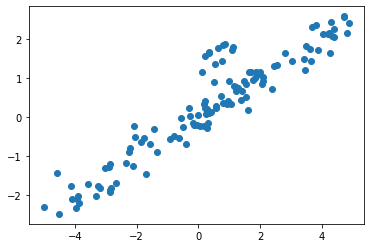

In [3]:
points = test_points(100,20)
plt.scatter(points[0],points[1])

## Exercise 7.1

In [4]:
##the line in homogeneous coordinates equals the cross product of two given points.
##l = p1xp2
def estimateline(p1,p2):
    p1 = np.hstack((p1,1))
    p2= np.hstack((p2,1))
    return np.cross(p1,p2)

In [5]:
p1 = points[:,1]
p2 = points[:,10]
line = estimateline(p1,p2)

In [6]:
np.hstack((p1,1))@line.T

-5.551115123125783e-17

In [7]:
np.hstack((p2,1))@line.T

-5.551115123125783e-17

## Exercise 7.2
$
dist = \frac{|Ax+By+C|}{sqrt(A^2+B^2)}
$

In [8]:
def isinlier(p,l,threshold):
    p = np.hstack((p,1))
    dist = np.abs(p@l.T)/np.sqrt(l[0]**2+l[1]**2)
    return dist<threshold

In [9]:
isinlier(p2,line,0.5)

True

In [10]:
isinlier(np.array([5,10]),line,0.5)

False

## Exercise 7.3

In [11]:
def consensus(p,l,threshold):
    #p = np.vstack((p,np.ones(len(p[0]))))
    number = 0
    for i in range(len(p[0])):
        if isinlier(p[:,i],l,threshold):
            number = number+1
    return number

In [12]:
consensus(points,line,0.25)

20

## Exercise 7.4

In [13]:
def randomDraws(p):
    index = np.random.choice(range(len(p[0])),2,False)
    points = p[:,index]
    #plt.scatter(points[0],points[1])
    return points

In [14]:
randomDraws(points)

array([[4.20013096, 0.22656918],
       [2.12433345, 0.40526771]])

## Exercise 7.5

In [15]:
def RANSAC(points,iterations,threshold):
##points inhomogenous coordinates
    maxnumber = 0   
    for i in range(iterations):
        point = randomDraws(points)
        p1 = point[:,0]
        p2 = point[:,1]
        line = estimateline(p1,p2)
        number = consensus(points,line,threshold)
        if number>maxnumber:
            maxnumber = number
            maxline = line
            
    return maxline

In [16]:
maxline = RANSAC(points,500,0.2)

In [17]:
maxline

array([ 2.04702553, -3.78285021, -0.22483967])

Ax+By+C =0,y = -(AX+C)/B

In [18]:
a = maxline[0]
b = maxline[1]
c = maxline[2]

x1 = points[0].min()
x2 = points[0].max()
y1 = -(a*x1+c)/b
y2 = -(a*x2+c)/b

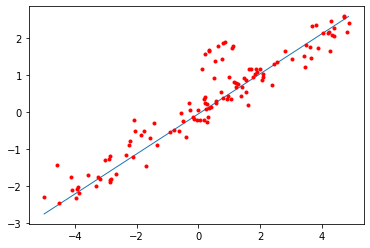

In [19]:
plt.plot([x1,x2],[y1,y2],linewidth = 1)
plt.plot(points[0,:],points[1,:],'.r')

## Exercise 7.7

In [20]:
def pca_line(x):
    d = np.cov(x)[:,0]  #Estimate a covariance matrix
    d /= np.linalg.norm(d)  #return 2-norm
    l = [d[1],-d[0]]
    l.append(-(l@x.mean(1)))
    return l

In [21]:
def RANSAC_Fit(points,iterations,threshold):
##points inhomogenous coordinates
    maxnumber = 0   
    inliersindex = []
    for i in range(iterations):
        point = randomDraws(points)
        p1 = point[:,0]
        p2 = point[:,1]
        line = estimateline(p1,p2)
        number = consensus(points,line,threshold)
        if number>maxnumber:
            maxnumber = number
            maxline = line
#find the index of inliers
    for i in range(len(points[0])):
        if isinlier(points[:,i],maxline,threshold):
            inliersindex.append(i)
    inliers = points[:,inliersindex]
#calculate fitline based on inliers
    fitline = pca_line(inliers)
    return fitline,inliers

In [22]:
fitline,inliers = RANSAC_Fit(points,500,0.2)

In [23]:
a = fitline[0]
b = fitline[1]
c = fitline[2]

x1 = points[0].min()
x2 = points[0].max()
y1 = -(a*x1+c)/b
y2 = -(a*x2+c)/b

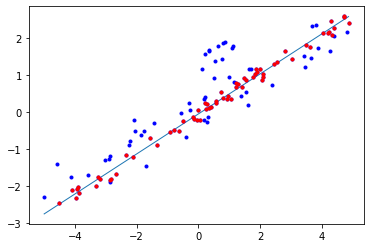

In [24]:
plt.plot([x1,x2],[y1,y2],linewidth = 1)
plt.plot(points[0,:],points[1,:],'.b')
plt.plot(inliers[0,:],inliers[1,:],'.r')

## Exercise 7.8

In [25]:
def RANSAC_Fit_stop(points,iterations,threshold,p):
##points inhomogenous coordinates
    maxnumber = 0   
    inliersindex = []
    iternationnum = 0
    m = len(points[0])
    N_hat = iterations
    while iternationnum<N_hat:
        point = randomDraws(points)
        p1 = point[:,0]
        p2 = point[:,1]
        line = estimateline(p1,p2)
        number = consensus(points,line,threshold)
        if number>maxnumber:
            maxnumber = number
            maxline = line
            epsilon = 1-maxnumber/m
            N_hat = np.log(1-p)/np.log((1-(1-epsilon)**2)) #we need 2 data points to fit a single model,n=2
        iternationnum = iternationnum +1            
            
    for i in range(len(points[0])):
        if isinlier(points[:,i],maxline,threshold):
            inliersindex.append(i)
    
    inliers = points[:,inliersindex]
    fitline = pca_line(inliers)
    print("we have done %d iterations" % iternationnum)
    return fitline,inliers

In [26]:
fitline,inliers = RANSAC_Fit_stop(points,1000,0.2,0.99)

we have done 16 iterations


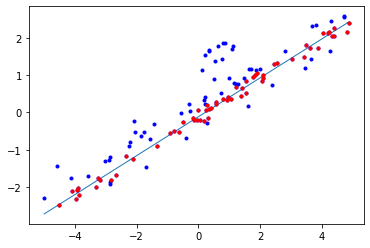

In [27]:
a = fitline[0]
b = fitline[1]
c = fitline[2]

x1 = points[0].min()
x2 = points[0].max()
y1 = -(a*x1+c)/b
y2 = -(a*x2+c)/b

plt.plot([x1,x2],[y1,y2],linewidth = 1)
plt.plot(points[0,:],points[1,:],'.b')
plt.plot(inliers[0,:],inliers[1,:],'.r')